# Process & Visualize ROI

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set()
from skimage import io

import processROI

## Tests

### test_get_masks

In [2]:
maskPattern = (
        "data/190603/aligned/" +
        "03_masks/*.bmp"
    )
masks = processROI.get_masks(maskPattern)
assert len(masks) == 57
assert all([x.shape == (512, 512) for x in masks])
assert np.sum(masks[0]) == 223
assert np.sum(masks[9]) == 163

### test_open_TIFF_stack

In [303]:
tiffsPattern = (
    "data/190603/aligned/" +
    "HN1953_190603_field1_00003_0000*.tif"
)
import glob
stack = processROI.open_TIFF_stack(tiffsPattern)
print(stack.shape)

(11679, 512, 512)


### test_cut_to_averages

In [4]:
ROIaverages = processROI.cut_to_averages(stack, masks)
assert np.all(ROIaverages != 0)
assert round(ROIaverages[0, 0]) == 122
assert round(ROIaverages[200, 0]) == 155
assert round(ROIaverages[400, 3]) == 82

## Process & Show
Using only a single example session

## Trial Averages

Looking at a window 500ms before to 1500ms after inhalation onset

In [5]:
h5Filename = (
    "data/190603/" +
    "1953_1_04_D2019_6_3T12_29_13_odor.h5"
)
trialsMeta = processROI.get_trials_metadata(h5Filename)
timelocks = trialsMeta['inh_onset']
preWindow = 500
postWindow = 1500

3 blocks, each block: 1: blank, 2-8: 100A -> 0A, 9-15: 0A -> 100A. A and B always complement

In [306]:
import pandas as pd
numBlocks = 3
numTrials = 15
blockTemplate = {'100% A, 0% B': [2, 15],
        '90% A, 10% B': [3, 14],
        '75% A, 25% B': [4, 13],
        '50% A, 50% B': [5, 12],
        '25% A, 75% B': [6, 11],
        '10% A, 90% B': [7, 10],
        '0% A, 100% B': [8, 9],}
trialGroups = {key: (np.tile(value, (numBlocks,1)) + (np.arange(numBlocks) * numTrials).reshape(numBlocks,1)).flatten() - 1
               for key, value in blockTemplate.items()}
trialGroups = pd.DataFrame(data=trialGroups)
# Print the trial names' numbers, not the 0-index values as stored
print(trialGroups + 1)

   100% A, 0% B  90% A, 10% B  75% A, 25% B  50% A, 50% B  25% A, 75% B  \
0             2             3             4             5             6   
1            15            14            13            12            11   
2            17            18            19            20            21   
3            30            29            28            27            26   
4            32            33            34            35            36   
5            45            44            43            42            41   

   10% A, 90% B  0% A, 100% B  
0             7             8  
1            10             9  
2            22            23  
3            25            24  
4            37            38  
5            40            39  


In [310]:
trialPreTimelocks = pd.DataFrame()
trialPostTimelocks = pd.DataFrame()
trialTimelocks = pd.DataFrame()
for key in trialGroups:
    trialPreTimelocks[key] = timelocks.iloc[trialGroups[key]].values - preWindow
    trialPostTimelocks[key] = timelocks.iloc[trialGroups[key]].values + postWindow
    trialTimelocks[key] = timelocks.iloc[trialGroups[key]].values
print("Pretrial Timestamps")
print(trialPreTimelocks)
print("Timelock timestamps")
print(trialTimelocks)
print("Posttrial Timestamps")
print(trialPostTimelocks)

Pretrial Timestamps
   100% A, 0% B  90% A, 10% B  75% A, 25% B  50% A, 50% B  25% A, 75% B  \
0       2223344       2231862       2240059       2249221       2258588   
1       2340976       2332315       2324055       2315031       2304867   
2       2359564       2368786       2378415       2387439       2396560   
3       2476162       2467544       2458996       2450550       2441246   
4       2494215       2504229       2512636       2520986       2529236   
5       2612434       2602455       2593169       2583771       2574968   

   10% A, 90% B  0% A, 100% B  
0       2267569       2277534  
1       2295438       2286034  
2       2406089       2415096  
3       2432828       2424407  
4       2539131       2548498  
5       2566358       2558218  
Timelock timestamps
   100% A, 0% B  90% A, 10% B  75% A, 25% B  50% A, 50% B  25% A, 75% B  \
0       2223844       2232362       2240559       2249721       2259088   
1       2341476       2332815       2324555       2315531   

In [287]:
key = "0% A, 100% B"
preFrames = processROI.frame_from_timestamp(h5Filename,trialPreTimelocks[key])
lockFrames = processROI.frame_from_timestamp(h5Filename, trialTimelocks[key])
postFrames = processROI.frame_from_timestamp(h5Filename,trialPostTimelocks[key])

In [311]:
print(f"Prewindow lengths for each trial: {[lock-pre for pre, lock in zip(preFrames, lockFrames)]}")

Prewindow lengths for each trial: [15, 15, 14, 15, 15, 15]


#### Calc meanF

In [289]:
frameWindow = 2
print(ROIaverages.shape)
print(np.mean(ROIaverages[3520-2:3520+2, :]))
meanFs = [np.mean(ROIaverages[max(0,lock-frameWindow): lock+frameWindow,:], axis=0)
          for lock in lockFrames]
meanFs = np.array(meanFs)
print(meanFs.shape)
# print(meanFs)

(11679, 57)
211.23283541883396
(6, 57)


In [290]:
numROI = ROIaverages.shape[1]
numTrials = len(lockFrames)
maxSliceWidth = max([post - pre for pre, post in zip(preFrames, postFrames)])
trialAverageData = np.zeros((maxSliceWidth, numTrials, numROI))
zeroFrame = max(lock - pre for pre, lock in zip(preFrames, lockFrames))
# print(trialAverageData)
print(zeroFrame)

15


In [291]:
preWindows = [slice(pre,lock) for pre,lock in zip(preFrames, lockFrames)]
print(preWindows)

[slice(1606, 1621, None), slice(1860, 1875, None), slice(5724, 5738, None), slice(6002, 6017, None), slice(9717, 9732, None), slice(10008, 10023, None)]


In [292]:
for i_slice, slce in enumerate(preWindows):
    tempData = ROIaverages[slce,:]
#     print(tempData.shape[0])
    trialAverageData[zeroFrame-tempData.shape[0]:zeroFrame, i_slice, :] = tempData
#     print(trialAverageData[:zeroFrame,i_slice,0])

In [293]:
postWindows = [slice(lock,post) for lock,post in zip(lockFrames, postFrames)]
print(postWindows)

[slice(1621, 1666, None), slice(1875, 1920, None), slice(5738, 5783, None), slice(6017, 6062, None), slice(9732, 9777, None), slice(10023, 10068, None)]


In [294]:
for i_slice, slce in enumerate(postWindows):
    tempData = ROIaverages[slce,:]
#     print(tempData.shape[0])
    trialAverageData[zeroFrame:zeroFrame+tempData.shape[0], i_slice, :] = tempData
#     print(trialAverageData[zeroFrame:,i_slice,0])

### Calc dF/F

In [295]:
[(trialAverageData[:,x,:]==0).nonzero()[0].shape for x in range(6)]

[(0,), (0,), (57,), (0,), (0,), (0,)]

In [296]:
dF_F = trialAverageData / meanFs.reshape(1,6,57) - 1
dF_F[dF_F == -1] = np.nan
print(dF_F.shape)
(np.mean(dF_F,axis=2) == -1).nonzero()[0].shape

(60, 6, 57)


(0,)

In [297]:
lockOffset = list(range(-zeroFrame, maxSliceWidth-zeroFrame))
print(lockOffset)

[-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]


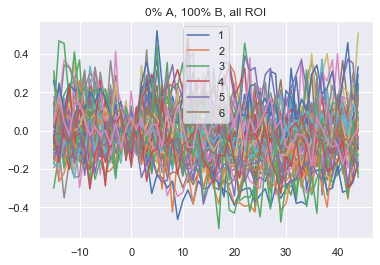

In [304]:
plt.plot(lockOffset, np.nanmean(dF_F, axis=1))
plt.title(key + ", all ROI")
plt.legend(list(range(1, dF_F.shape[1]+1)))

/Users/jonathanshor/.local/share/virtualenvs/rinberg-rotation-6TUwHcAB/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


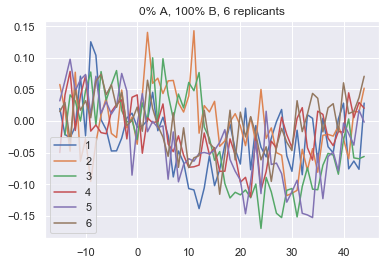

In [300]:
plt.plot(lockOffset, np.nanmean(dF_F,axis=2))
plt.title(key + ", 6 replicants")
plt.legend(list(range(1,7)))

Text(0.5, 1.0, '0% A, 100% B, Cross-trial Mean')

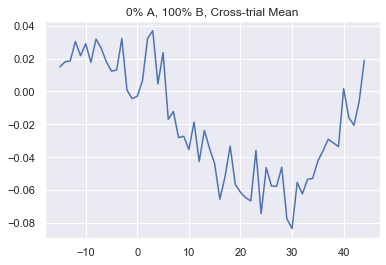

In [312]:
plt.plot(lockOffset, np.nanmean(dF_F, axis=(1,2)))
plt.title(key + ", Cross-trial Mean")